# Training the RPN signature on multi-center data

- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/1_multi-center_training.ipynb

- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature

- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3

- Raw data from center 3 is available upon reasonable request.

### Imports

In [1]:
import sys
sys.path.append('../')
from PAINTeR import connectivity # in-house lib used for the RPN-signature
from PAINTeR import plot # in-house lib used for the RPN-signature
from PAINTeR import model # in-house lib used for the RPN-signature
import numpy as np # hi old friend
import pandas as pd

from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure

from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from sklearn.linear_model import ElasticNet, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, KFold, GroupKFold, LeavePGroupsOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import scipy.stats as stats
import joblib

/opt/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Load and merge behavioral data for all three centers (after exclusions)

In [2]:
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
df

,index,Unnamed: 0,ID,Excluded,exclusion_crit,Male,day_menses,Age,height,weight,...,weight..kg.,psq_moderate,psq_minor,PSQ20,PSQI,MDT_log_geom,Pulse_MRI,Pulse_QST,BDI,PSQ20_essen
0,0,0,4,0.0,NaN,1.0,NaN,25.552361,175.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,6,0.0,NaN,1.0,NaN,33.453799,183.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,7,0.0,NaN,1.0,NaN,26.119097,186.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,8,0.0,NaN,1.0,NaN,25.445585,180.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,9,0.0,NaN,0.0,6.0,22.573580,176.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,14,14,22,0.0,NaN,1.0,NaN,24.000000,185.0,82.0,...,NaN,27.0,11.0,6.0,1.0,-1.259900,73.0,76.0,5.0,24.0
87,15,15,24,0.0,NaN,1.0,NaN,22.000000,183.0,83.0,...,NaN,28.0,16.0,9.0,1.0,-1.913513,85.0,86.0,0.0,25.0
88,16,16,25,0.0,NaN,1.0,NaN,22.000000,195.0,77.0,...,NaN,20.0,9.0,11.0,NaN,-1.581106,88.0,91.0,1.0,25.0
89,17,17,28,0.0,NaN,0.0,5.0,23.000000,162.0,59.0,...,NaN,34.0,18.0,43.0,2.0,-1.145363,78.0,89.0,7.0,37.0


## Load preprocessed and scrubbed timeseries data

<AxesSubplot:>

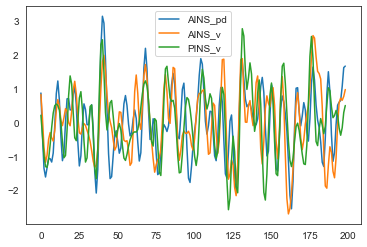

In [3]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'
    
    ts = pd.read_csv(f_scrub).iloc[:,1:] # here we can omit global signal...
    
    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd 
    
    perc_scrubbed.append(100 - 100*len(ts.shape)/len(fd) )
    timeseries.append(ts.values)
    
# double check visually
sub_idx=10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()

## Load region and module names for the MIST122 atlas

In [4]:
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

## Calculate functional connectivity as partial correlation

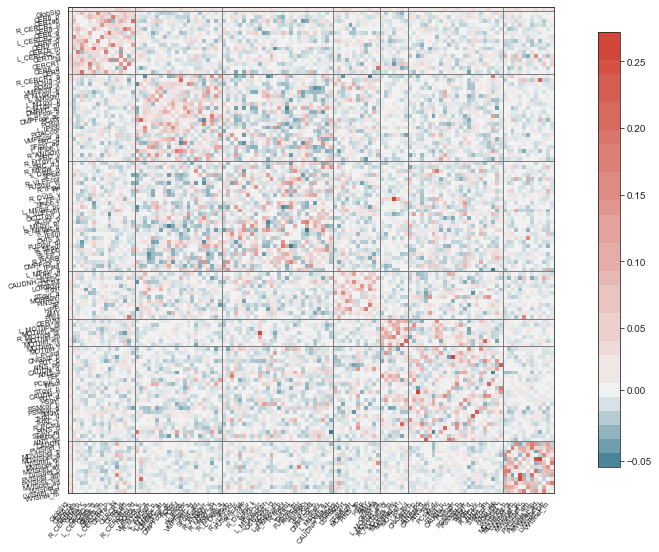

In [6]:
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
X = correlation_measure.fit_transform(timeseries) # these are the features
joblib.dump(X, "../res/multi-center/all_features.joblib")

# double-check the mean matrix visually
mat=correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0 # zero diag
plot.plot_matrix(mat, labels, modules)

## Create groups to balance the cross-validations across centers

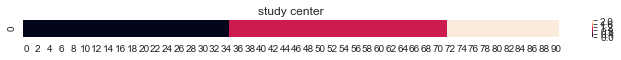

35 37 19


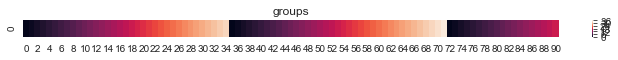

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18])

In [6]:

plt.figure(figsize=(12, 0.3))
sns.heatmap([df.study.astype("category").cat.codes.values]).set_title('study center')
plt.show()
n_szeged = np.sum(df.study == 'szeged') # size of the smallest study
n_essen = np.sum(df.study == 'essen')
n_bochum = np.sum(df.study == 'bochum')
print(n_bochum, n_essen, n_szeged)

groups=np.zeros(len(df), dtype=int)

g=0
i=0
while i < n_bochum:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
    
g=0
i=n_bochum
while i < n_bochum+n_essen:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
g=0
i=n_bochum+n_essen
while i < len(df):
    groups[i] = g
    i += 1
    g += 1
    
plt.figure(figsize=(12, 0.3))
sns.heatmap([groups]).set_title('groups')
plt.show()

groups

## Pain sensitivity as target variable

In [7]:
y = df.mean_QST_pain_sensitivity

## Define model to be trained

In [8]:
# an oversimplified factory-function, defining the model to be trained:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          p_grid={'fsel__k': [25, 50, 100, 1000, 3000],
                              'model__alpha': [.001, .005, .01, .05, .1, .5, 1, 5],
                              'model__l1_ratio': [0.0001, .25, .5, .75, 0.9999]         
                                   }):
                                      
    mymodel = Pipeline(
        [
         ('fsel', fsel),
         ('scaler', scaler),
         ('model', model)])
    return mymodel, p_grid

In [9]:
model, p_grid = pipe_scale_fsel_elnet()

## Do a non-nested, balanced cross validation, to optimize hyperparameters, then retain the final multi-center model

In [10]:
cv = GroupKFold(30)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)
clf.fit(X, y, groups=groups)

cv_pred = cross_val_predict(clf.best_estimator_, X, y, cv=cv, groups=groups, n_jobs=-1)                                 

Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 3951 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 4501 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 5151 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 5901 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 31.8min finished


### Print out some non-nested accuracy eestiomates and plot the non-nested prediction (overly optimistic).

**** Non-nested analysis ****
** Best hyperparameters: {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999}
** Score on full data as training set:	-0.0011958891155227323
** Score on mean as model: -0.5655535039999882
** Best Non-nested cross-validated score on test:	-0.27371984308172814
XXXXX Explained Variance: 0.5160142388902362


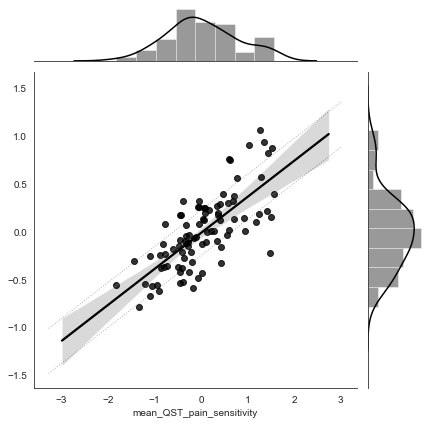

In [11]:
print("**** Non-nested analysis ****")
print("** Best hyperparameters: " + str(clf.best_params_))

print("** Score on full data as training set:\t" + str(-mean_squared_error(y_pred=clf.best_estimator_.predict(X), y_true=y)))
print("** Score on mean as model: " + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Best Non-nested cross-validated score on test:\t" + str(clf.best_score_))
print("XXXXX Explained Variance: " + str(
        1 - clf.best_score_ / -mean_squared_error(np.repeat(y.mean(), len(y)), y)))
plot.plot_prediction(y, cv_pred, sd=True, covar=[])

### Save finalized model and non-nested predictions (just in case)

In [12]:
joblib.dump(clf.best_estimator_, '../res/multi-center/finalized_model_multi-center.joblib')
# save NON-nested cv-predictions
np.savetxt("../res/multi-center/nonnested_cv_pred_full_GroupKFold30.csv", cv_pred, delimiter=",")

## Do a nested, balanced cross-validation, to obtain unbiased accuracy estimates

In [13]:
# we use the same model
model, p_grid = pipe_scale_fsel_elnet()

outer_cv = GroupKFold(30)
inner_cv = GroupKFold(30)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y, groups=groups):
    group_train = groups[train]  
    
    clf.fit(X[train], y[train], groups=group_train)
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2948 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 3847 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4297 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4847 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 5497 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 28.2min finished


cv: 0 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.3561685385466687 -0.18031180807008598
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1408 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 3408 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 4048 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4498 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 5048 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 5698 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 32.9min finished


cv: 1 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.3685929473619765 -0.021194820124262752
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 2944 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 3846 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4296 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4846 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 5496 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 33.7min finished


cv: 2 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.38311546567323007 -0.14839391295524587
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 3871 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4321 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4871 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 5521 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 30.6min finished


cv: 3 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.26319462727118004 -0.19424067836784287
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 3871 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4321 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4871 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 5521 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 29.9min finished


cv: 4 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.33310777886173704 -0.11297793099984749
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2936 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 3845 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4295 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4845 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 5495 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 29.8min finished


cv: 5 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.2973372040717675 -0.3761780001777166
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 2948 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 3846 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4296 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4846 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 5496 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 30.8min finished


cv: 6 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.3072527900564254 -0.11286593651588832
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2940 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 3845 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4295 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4845 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 5495 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 31.4min finished


cv: 7 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.35165214793928506 -0.12838291877990013
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 3981 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 5181 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 5931 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 20.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


cv: 8 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.36523081069074953 -0.07372916394039528
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.2min finished


cv: 9 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.9999} -0.3228851042281764 -0.23854873905342247
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 3879 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4329 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4879 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 5529 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 14.7min finished


cv: 10 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.3618835735917361 -0.454912601667457
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.4min finished


cv: 11 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.5} -0.3495402691287302 -0.8530515664414103
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 3923 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4284 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4745 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 5306 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 5956 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.2min finished


cv: 12 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.3193088040449919 -1.0588121466789895
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


cv: 13 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.30626061601558624 -0.43377338376564284
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 3803 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 4188 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4656 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 5206 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 5856 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.3min finished


cv: 14 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.28094426455166666 -0.05471096356794799
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 3879 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4329 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4879 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 5529 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.0min finished


cv: 15 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.38257263033246836 -0.14723304437012766
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 3879 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4329 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4879 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 5529 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 14.9min finished


cv: 16 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.75} -0.31663200655318985 -0.39972606525581317
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.6min finished


cv: 17 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.5} -0.3886687965204453 -0.32722597780262846
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 14.7min finished


cv: 18 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.3642349258918397 -0.5190256506111455
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 4081 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5081 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 5731 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.1min finished


cv: 19 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.2885846620630973 -0.40140721264272217
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 3926 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4287 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4748 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5309 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 5959 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 14.5min finished


cv: 20 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.32804961956884454 -0.12532041267254385
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.0min finished


cv: 21 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.35276578213292537 -0.42008656818280143
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.3min finished


cv: 22 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.38548008140605566 -1.0959503786538203
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 3910 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4271 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4732 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 5293 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 5943 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.5min finished


cv: 23 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.40217097910650224 -0.48511033325623576
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 14.8min finished


cv: 24 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.5} -0.373901858222486 -0.08088146241797306
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.4min finished


cv: 25 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.28446531788291834 -0.6275285901545896
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.7min finished


cv: 26 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.2967769393434868 -0.2575507939042939
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


cv: 27 {'fsel__k': 1000, 'model__alpha': 0.05, 'model__l1_ratio': 0.5} -0.37342664446205737 -0.42853843327040403
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.8min finished


cv: 28 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.5} -0.35563428265286817 -0.2620166541535564
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 4081 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 5081 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 5731 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.5min finished


cv: 29 {'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.31939203055616183 -0.09781906059627446


### Print out the unbiased, nested estimates and plot the (unbiased) nested-cv predictions

*** Score on mean as model:	-0.5655535039999882
** Mean score in the inner crossvaludation (inner_cv):	-0.3393077166243084
** Mean Nested Crossvalidation Score (outer_cv):	-0.33725017363503285
Explained Variance: 0.4036812233506383
Correlation: 0.6334375874860451


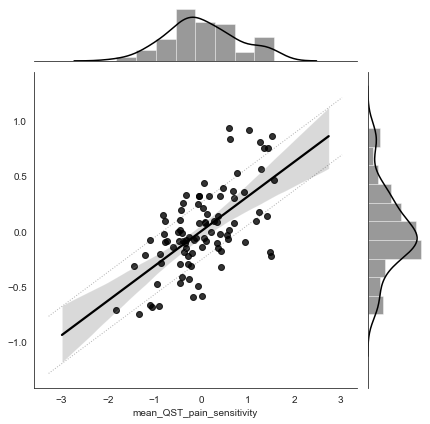

In [14]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

### Save the nested-cv predictions

In [15]:
# save nested predictions
np.savetxt("../res/multi-center/nested_cv_pred_full_GroupKFold30.csv", predicted, delimiter=",")